# Multilingual CLIP Linguistic Evaluation

### Install Requirements and Download OpenAI CLIP Model
This section might take some minutes. Alternatively, you can use the enviromnent.yml file to create conda environment.

In [1]:

import subprocess
CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

# if CUDA_version == "10.0":
#     torch_version_suffix = "+cu100"
# elif CUDA_version == "10.1":
#     torch_version_suffix = "+cu101"
# elif CUDA_version == "10.2":
#     torch_version_suffix = ""
# else:
#     torch_version_suffix = "+cu110"

# %pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
# %pip install ftfy==5.8 regex
# %pip install transformers

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os, random, subprocess
import torch
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

# %pip install git+https://github.com/openai/CLIP.git
import clip

# !git clone https://github.com/FreddeFrallan/Multilingual-CLIP
# %cd Multilingual-CLIP

# Download weights to load mclip models
# !bash ./legacy_get-weights.sh

CUDA version: 12.2


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Load The Multilingual Text Encoder

In [4]:
from multilingual_clip import legacy_multilingual_clip
text_model = legacy_multilingual_clip.load_model('M-BERT-Distil-40')  # ResNet50x6 Image encoder
# text_model = legacy_multilingual_clip.load_model('M-BERT-Base-ViT-B') # ViT-B/32 Image encoder

### Load The Matching CLIP Model

In [5]:
clip_model, compose = clip.load('RN50x4', device)
# clip_model, compose = clip.load('ViT-B/32', device)

In [6]:
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in clip_model.parameters()]):,}")

Model parameters: 178,300,601


### **Semantic Similarity Comparison (Cosine Similarity)**


In [7]:
import pandas as pd

def read_similarities(language, suffix="sim"):
    df = pd.read_csv(f'./datasets/similarities/wordsim353-{language.lower()}-{suffix}.txt', sep='\t', header=0, names=["word_1", "word_2", "score"])
    return df
  

In [8]:
from scipy.stats import spearmanr

def evaluate_similarities(language):
  # Read the human annotated data
  word_sim_df = read_similarities(language)
  
  # Get the word 1 column embeddings
  word_1_embeddings = text_model(word_sim_df['word_1'].tolist()).cpu().detach().numpy()
  
  # Get the word 2 column embeddings
  word_2_embeddings = text_model(word_sim_df['word_2'].tolist()).cpu().detach().numpy()
  
  # Compare the cosine similarities
  model_similarities = cosine_similarity(word_1_embeddings, word_2_embeddings).diagonal()
  
  # Normalize the similarities
  model_similarities = (model_similarities + 1) / 2

  # Compute Spearman's rank correlation
  spearman_rho, _ = spearmanr(model_similarities, word_sim_df['score'].values)
  
  # Add similarities to dataframe
  word_sim_df['model_similarities'] = model_similarities
  return spearman_rho, word_sim_df


### Spearman's rank correlation coefficient

In [9]:
languages = ['English', 'Italian', 'German', 'Russian']

print("------ Spearman's rank correlation coefficient for WordSim353 using M-CLIP Embeddings ------")
for lang in languages:
  rho, scores = evaluate_similarities(lang)
  print("{}: {}".format(lang, round(rho, 3)))


------ Spearman's rank correlation coefficient for WordSim353 using M-CLIP Embeddings ------
English: 0.19
Italian: 0.128
German: 0.172
Russian: 0.126


### Multilingual Dataset (Combining unqiue words from English and other languages)

In [10]:
languages = ['English', 'Italian', 'German', 'Russian']

all_words_df = pd.DataFrame(columns=[x.lower() for x in languages])

for lang in languages:
  # combine word 1 from English and other languages
  all_words_df[lang.lower()] = read_similarities(lang)['word_1']

# Drop rows with any duplicate english words
all_words_df = all_words_df.drop_duplicates(subset=['english']).reset_index(drop=True)
all_words_df

,english,italian,german,russian
0,tiger,tigre,Tiger,тигр
1,plane,aereo,Flugzeug,самолет
2,train,treno,Zug,поезд
3,television,televisione,Fernseher,телевидение
4,media,media,Medien,медиум
...,...,...,...,...
124,rock,rock,Rock,рок
125,museum,museo,Museum,музей
126,observation,osservazione,Betrachtung,наблюдение
127,shower,doccia,Regen,ливень


### Compare words embeddings between languages and get dissimilar words


In [11]:

def extract_similarities(word_list, comparing_with='english', languages=['italian', 'german', 'russian'], threshold=0.85):
  if word_list is None:
    raise ValueError("word_list cannot be None")
  
  if comparing_with not in word_list.columns:
    raise ValueError("comparing_with must be a column in word_list")
  
  if languages is None or len(languages) == 0:
    raise ValueError("languages cannot be None")
  
  if len([lang for lang in languages if lang not in word_list.columns]) > 0:
    raise ValueError("languages must be a column in word_list")
  
  # Create a variable to store all languages
  all_languages = [comparing_with] + languages
  
  # Create a dataframe to store the dissimilar words, i.e. words with cosine similarity below the threshold
  dissimilar_words = pd.DataFrame(columns=all_languages)
  
  # Store the cosine similarity score
  word_similarities = pd.DataFrame(columns=all_languages)
  
  # Store the words embeddings for each language
  word_embeddings = pd.DataFrame(columns= ['word'] + all_languages)
  
  # Fill the words in the dataframe
  word_similarities[comparing_with] = word_list[comparing_with]
  dissimilar_words[comparing_with] = word_list[comparing_with]
  word_embeddings['word'] = word_list[comparing_with].tolist()
 
  # Get the comparing_with language embeddings
  comparing_language_embds = text_model(word_list[comparing_with].tolist()).cpu().detach().numpy()
  word_embeddings[comparing_with] = comparing_language_embds.tolist()

  for lang in languages:
    # Get the word embeddings for different languages
    embds = text_model(word_list[lang].tolist()).cpu().detach().numpy()
    word_embeddings[lang] = embds.tolist()
  
    # Compute cosine similarity
    similarities = cosine_similarity(comparing_language_embds, embds).diagonal()

    # Save the similarity scores
    word_similarities[lang] = similarities
  
    # Save the dissimilar words based on the threshold otherwise set empty string if similar
    dissimilar_words[lang] = [word_list[lang][i] if similarities[i] < threshold else np.nan for i in range(len(word_list[lang]))]

  
  # Remove the rows with empty strings in the dissimilar words
  dissimilar_words = dissimilar_words.dropna(subset=languages, how='all').replace(np.nan, '', regex=True).reset_index(drop=True)
  
  return dissimilar_words, word_similarities, word_embeddings
  

### Calculate dissimilar words count at different thrshold - 0.95, 0.9, 0.85, 0.8

In [14]:
dissimilar_words_df = pd.DataFrame(columns=['Threshold', 'German', 'Italian', 'Russian'])
for i, threshold in enumerate([0.95, 0.9, 0.85, 0.8]):
  dissimilar_words, word_similarities, word_embeddings = extract_similarities(word_list=all_words_df, threshold=threshold)
  dissimilar_words_df.at[i, 'Threshold'] = threshold
  dissimilar_words_df.at[i, 'German'] = dissimilar_words['german'].where(dissimilar_words['german'].str.len() > 0).count()
  dissimilar_words_df.at[i, 'Italian'] = dissimilar_words['italian'].where(dissimilar_words['italian'].str.len() > 0).count()
  dissimilar_words_df.at[i, 'Russian'] = dissimilar_words['russian'].where(dissimilar_words['russian'].str.len() > 0).count()

In [15]:
dissimilar_words_df

,Threshold,German,Italian,Russian
0,0.95,24,27,29
1,0.9,8,10,11
2,0.85,2,4,3
3,0.8,0,1,0


### Dimensionality reduction of the embeddings using PCA

In [13]:
from sklearn.decomposition import PCA

# Reduce the dimensionality of the embeddings
def get_reduced_embeddings(word_list, word_embeddings, n_words=None):
  
  # Get the n words from the words list
  all_words = word_list[:n_words].melt(value_vars=word_embeddings.columns[1:].tolist(), var_name='language', value_name='word')
  
  # Merge the words with their embeddings
  merged_df = all_words.merge(word_embeddings[:n_words].melt(id_vars='word', value_vars=word_embeddings.columns[1:].tolist(), var_name='language', value_name='embedding'), left_index=True, right_index=True)
  
  # Rename the columns
  merged_df = merged_df.drop(columns=['language_y']).rename(columns={'language_x': 'language', 'word_y': 'word_english', 'word_x': 'word_multilingual'})

  # Extract embeddings and corresponding metadata
  embeddings = np.vstack(merged_df['embedding'])
  
  # Reduce dimensions using PCA
  pca = PCA(n_components=2)
  reduced_embeddings = pca.fit_transform(embeddings)
  
  merged_df['reduced_embedding'] = reduced_embeddings.tolist()
  
  return merged_df

### **Visualize the embeddings with reduced dimensionality**

In [32]:
_, _, word_embeddings = extract_similarities(word_list=all_words_df)

# For 10 words
merged_df = get_reduced_embeddings(all_words_df, word_embeddings, 10)

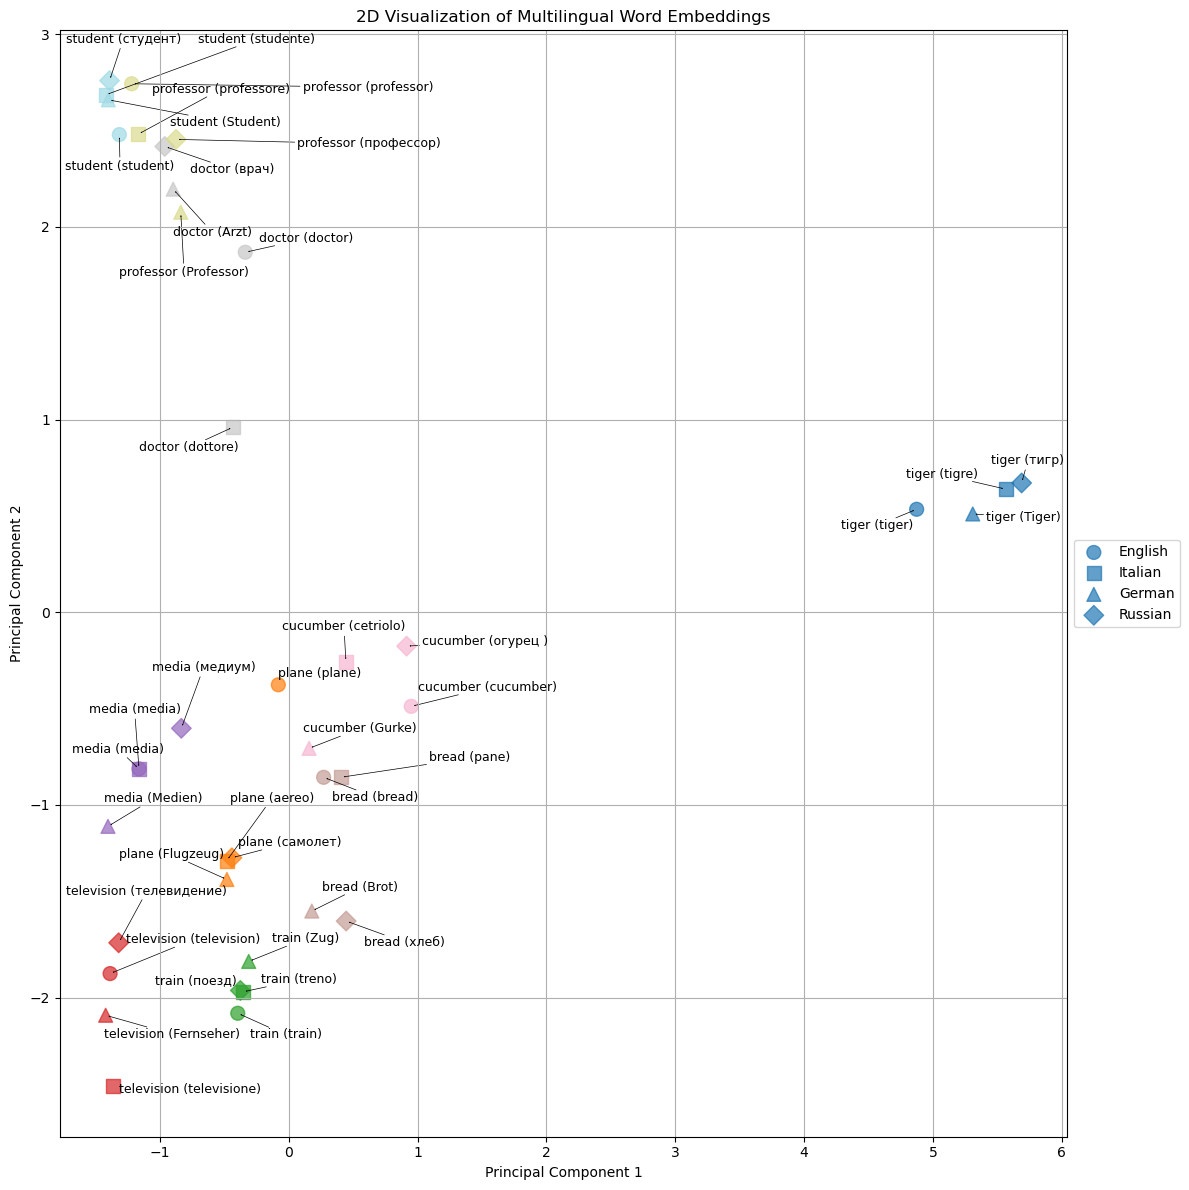

In [33]:
import matplotlib.pyplot as plt
from adjustText import adjust_text  # Import adjust_text for automatic text adjustment
import pandas as pd

# Assuming `merged_df` is already populated with the relevant data
# Create a list of unique languages
languages = merged_df['language'].unique()

# Define markers for each language
markers = ['o', 's', '^', 'D']  # Marker styles for each language

# Create a list of unique English words (word pairs)
unique_words = merged_df['word_english'].unique()

# Assign a unique color to each word pair
color_map = plt.cm.get_cmap('tab20', len(unique_words))
word_to_color = {word: color_map(i) for i, word in enumerate(unique_words)}

# Initialize the plot
plt.figure(figsize=(12, 12))

# Plot each word with its corresponding reduced embedding
texts = []  # List to store Text instances for adjust_text

for i, language in enumerate(languages):
    subset = merged_df[merged_df['language'] == language]
    scatter = plt.scatter(subset['reduced_embedding'].apply(lambda x: x[0]),  # x coordinate
                          subset['reduced_embedding'].apply(lambda x: x[1]),  # y coordinate
                          marker=markers[i % len(markers)],  # cycle through markers
                          color=[word_to_color[word] for word in subset['word_english']],  # color by word pair
                          label=language.capitalize(),
                          alpha=0.7,                        # transparency of points
                          s=100)                            # marker size

    # Annotate each point with the corresponding word
    for index, row in subset.iterrows():
        texts.append(plt.text(row['reduced_embedding'][0], row['reduced_embedding'][1], 
                              f"{row['word_english']} ({row['word_multilingual']})",  # text to display
                              ha='center', va='center', fontsize=9))  # center alignment and font size

# Adjust text labels to avoid overlap
adjust_text(texts,  expand=(1.0, 2.5), arrowprops=dict(arrowstyle="->", color='black', lw=0.5)) 

# Add labels and title
plt.title('2D Visualization of Multilingual Word Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.tight_layout()
plt.grid(True)
plt.show()


### **Visualize homonyms along with two different context**

In [18]:
from matplotlib.ticker import MultipleLocator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

def visualize_homonyms(language, n_words=10):
    # Load the homonyms CSV file
    homonyms_df = pd.read_csv(f"./datasets/homonyms/homonyms-{language.lower()}.txt", names=['Homonym', 'Context1', 'Context2', 'Context1Word', 'Context2Word'], sep='\t')
    homonyms_df = homonyms_df[:n_words]

    # Get the embeddings
    Homonym_embds = text_model(homonyms_df['Homonym'].tolist()).cpu().detach().numpy()
    Context1_embds = text_model(homonyms_df['Context1'].tolist()).cpu().detach().numpy()
    Context2_embds = text_model(homonyms_df['Context2'].tolist()).cpu().detach().numpy()
    Context1Word_embds = text_model(homonyms_df['Context1Word'].tolist()).cpu().detach().numpy()
    Context2Word_embds = text_model(homonyms_df['Context2Word'].tolist()).cpu().detach().numpy()

    # Combine the embeddings into a single array for dimensionality reduction
    all_embeddings = np.vstack((Homonym_embds, Context1_embds, Context2_embds, Context1Word_embds, Context2Word_embds))

    # Standardize the embeddings
    scaler = StandardScaler()
    all_embeddings_scaled = scaler.fit_transform(all_embeddings)

    # Perform dimensionality reduction
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(all_embeddings_scaled)

    # Split the reduced embeddings back into Homonym, Context1, Context2, Context1Word, and Context2Word
    homonym_reduced = reduced_embeddings[:len(homonyms_df)]
    context1_reduced = reduced_embeddings[len(homonyms_df):len(homonyms_df) * 2]
    context2_reduced = reduced_embeddings[len(homonyms_df) * 2:len(homonyms_df) * 3]
    context1word_reduced = reduced_embeddings[len(homonyms_df) * 3:len(homonyms_df) * 4]
    context2word_reduced = reduced_embeddings[len(homonyms_df) * 4:]

    # Determine the axis limits and add a margin
    all_reduced = np.vstack((homonym_reduced, context1_reduced, context2_reduced, context1word_reduced, context2word_reduced))
    x_min, x_max = all_reduced[:, 0].min(), all_reduced[:, 0].max()
    y_min, y_max = all_reduced[:, 1].min(), all_reduced[:, 1].max()
    margin = 0.1 * (x_max - x_min)  # 10% margin

    x_min -= margin
    x_max += margin
    y_min -= margin
    y_max += margin

    # Plot the embeddings side by side
    fig, axes = plt.subplots(1, 2, figsize=(30, 15))  # Increased figure size
    colors = plt.cm.get_cmap('tab20', len(homonyms_df))

    # Plot Homonym, Context1, and Context1Word
    texts = []
    for i in range(len(homonyms_df)):
        axes[0].scatter(homonym_reduced[i, 0], homonym_reduced[i, 1], color=colors(i), label=f"{homonyms_df['Homonym'][i]} (Homonym)", s=150)  # Increased marker size
        axes[0].scatter(context1_reduced[i, 0], context1_reduced[i, 1], color=colors(i), marker='^', label=f"{homonyms_df['Context1'][i]} ({homonyms_df['Homonym'][i]} C1)", s=150)
        axes[0].scatter(context1word_reduced[i, 0], context1word_reduced[i, 1], color=colors(i), marker='x', label=f"{homonyms_df['Context1Word'][i]} ({homonyms_df['Homonym'][i]} C1W)", s=150)

        # Add labels
        texts.append(axes[0].text(homonym_reduced[i, 0], homonym_reduced[i, 1], f"{homonyms_df['Homonym'][i]} (H)", fontsize=14, wrap=True))  # Increased font size
        texts.append(axes[0].text(context1_reduced[i, 0], context1_reduced[i, 1], f"{homonyms_df['Context1'][i]} (C1)", fontsize=14, wrap=True))
        texts.append(axes[0].text(context1word_reduced[i, 0], context1word_reduced[i, 1], f"{homonyms_df['Context1Word'][i]} (C1W)", fontsize=14, wrap=True))

    adjust_text(texts, ax=axes[0], expand=(1.0, 3.5), arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    axes[0].set_title("Homonyms and Context1 Embeddings", fontsize=18)  # Increased title font size
    axes[0].set_xlabel("Component 1", fontsize=16)  # Increased label font size
    axes[0].set_ylabel("Component 2", fontsize=16)
    axes[0].set_xlim(x_min, x_max)  # Set x-axis limits
    axes[0].set_ylim(y_min, y_max)  # Set y-axis limits
    axes[0].legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize='medium')
    axes[0].xaxis.set_major_locator(MultipleLocator(2))
    axes[0].yaxis.set_major_locator(MultipleLocator(2))
    axes[0].grid(True)

    # Plot Homonym, Context2, and Context2Word
    texts = []
    for i in range(len(homonyms_df)):
        axes[1].scatter(homonym_reduced[i, 0], homonym_reduced[i, 1], color=colors(i), label=f"{homonyms_df['Homonym'][i]} (Homonym)", s=150)  # Increased marker size
        axes[1].scatter(context2_reduced[i, 0], context2_reduced[i, 1], color=colors(i), marker='^', label=f"{homonyms_df['Context2'][i]} ({homonyms_df['Homonym'][i]} C2)", s=150)
        axes[1].scatter(context2word_reduced[i, 0], context2word_reduced[i, 1], color=colors(i), marker='x', label=f"{homonyms_df['Context2Word'][i]} ({homonyms_df['Homonym'][i]} C2W)", s=150)

        # Add labels
        texts.append(axes[1].text(homonym_reduced[i, 0], homonym_reduced[i, 1], f"{homonyms_df['Homonym'][i]} (H)", fontsize=14, wrap=True))  # Increased font size
        texts.append(axes[1].text(context2_reduced[i, 0], context2_reduced[i, 1], f"{homonyms_df['Context2'][i]} (C2)", fontsize=14, wrap=True))
        texts.append(axes[1].text(context2word_reduced[i, 0], context2word_reduced[i, 1], f"{homonyms_df['Context2Word'][i]} (C2W)", fontsize=14, wrap=True))

    adjust_text(texts, ax=axes[1], expand=(1.0, 3.5), arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    axes[1].set_title("Homonyms and Context2 Embeddings", fontsize=18)  # Increased title font size
    axes[1].set_xlabel("Component 1", fontsize=16)  # Increased label font size
    axes[1].set_ylabel("Component 2", fontsize=16)
    axes[1].set_xlim(x_min, x_max)  # Set x-axis limits
    axes[1].set_ylim(y_min, y_max)  # Set y-axis limits
    axes[1].legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize='medium')
    axes[1].xaxis.set_major_locator(MultipleLocator(2))
    axes[1].yaxis.set_major_locator(MultipleLocator(2))
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


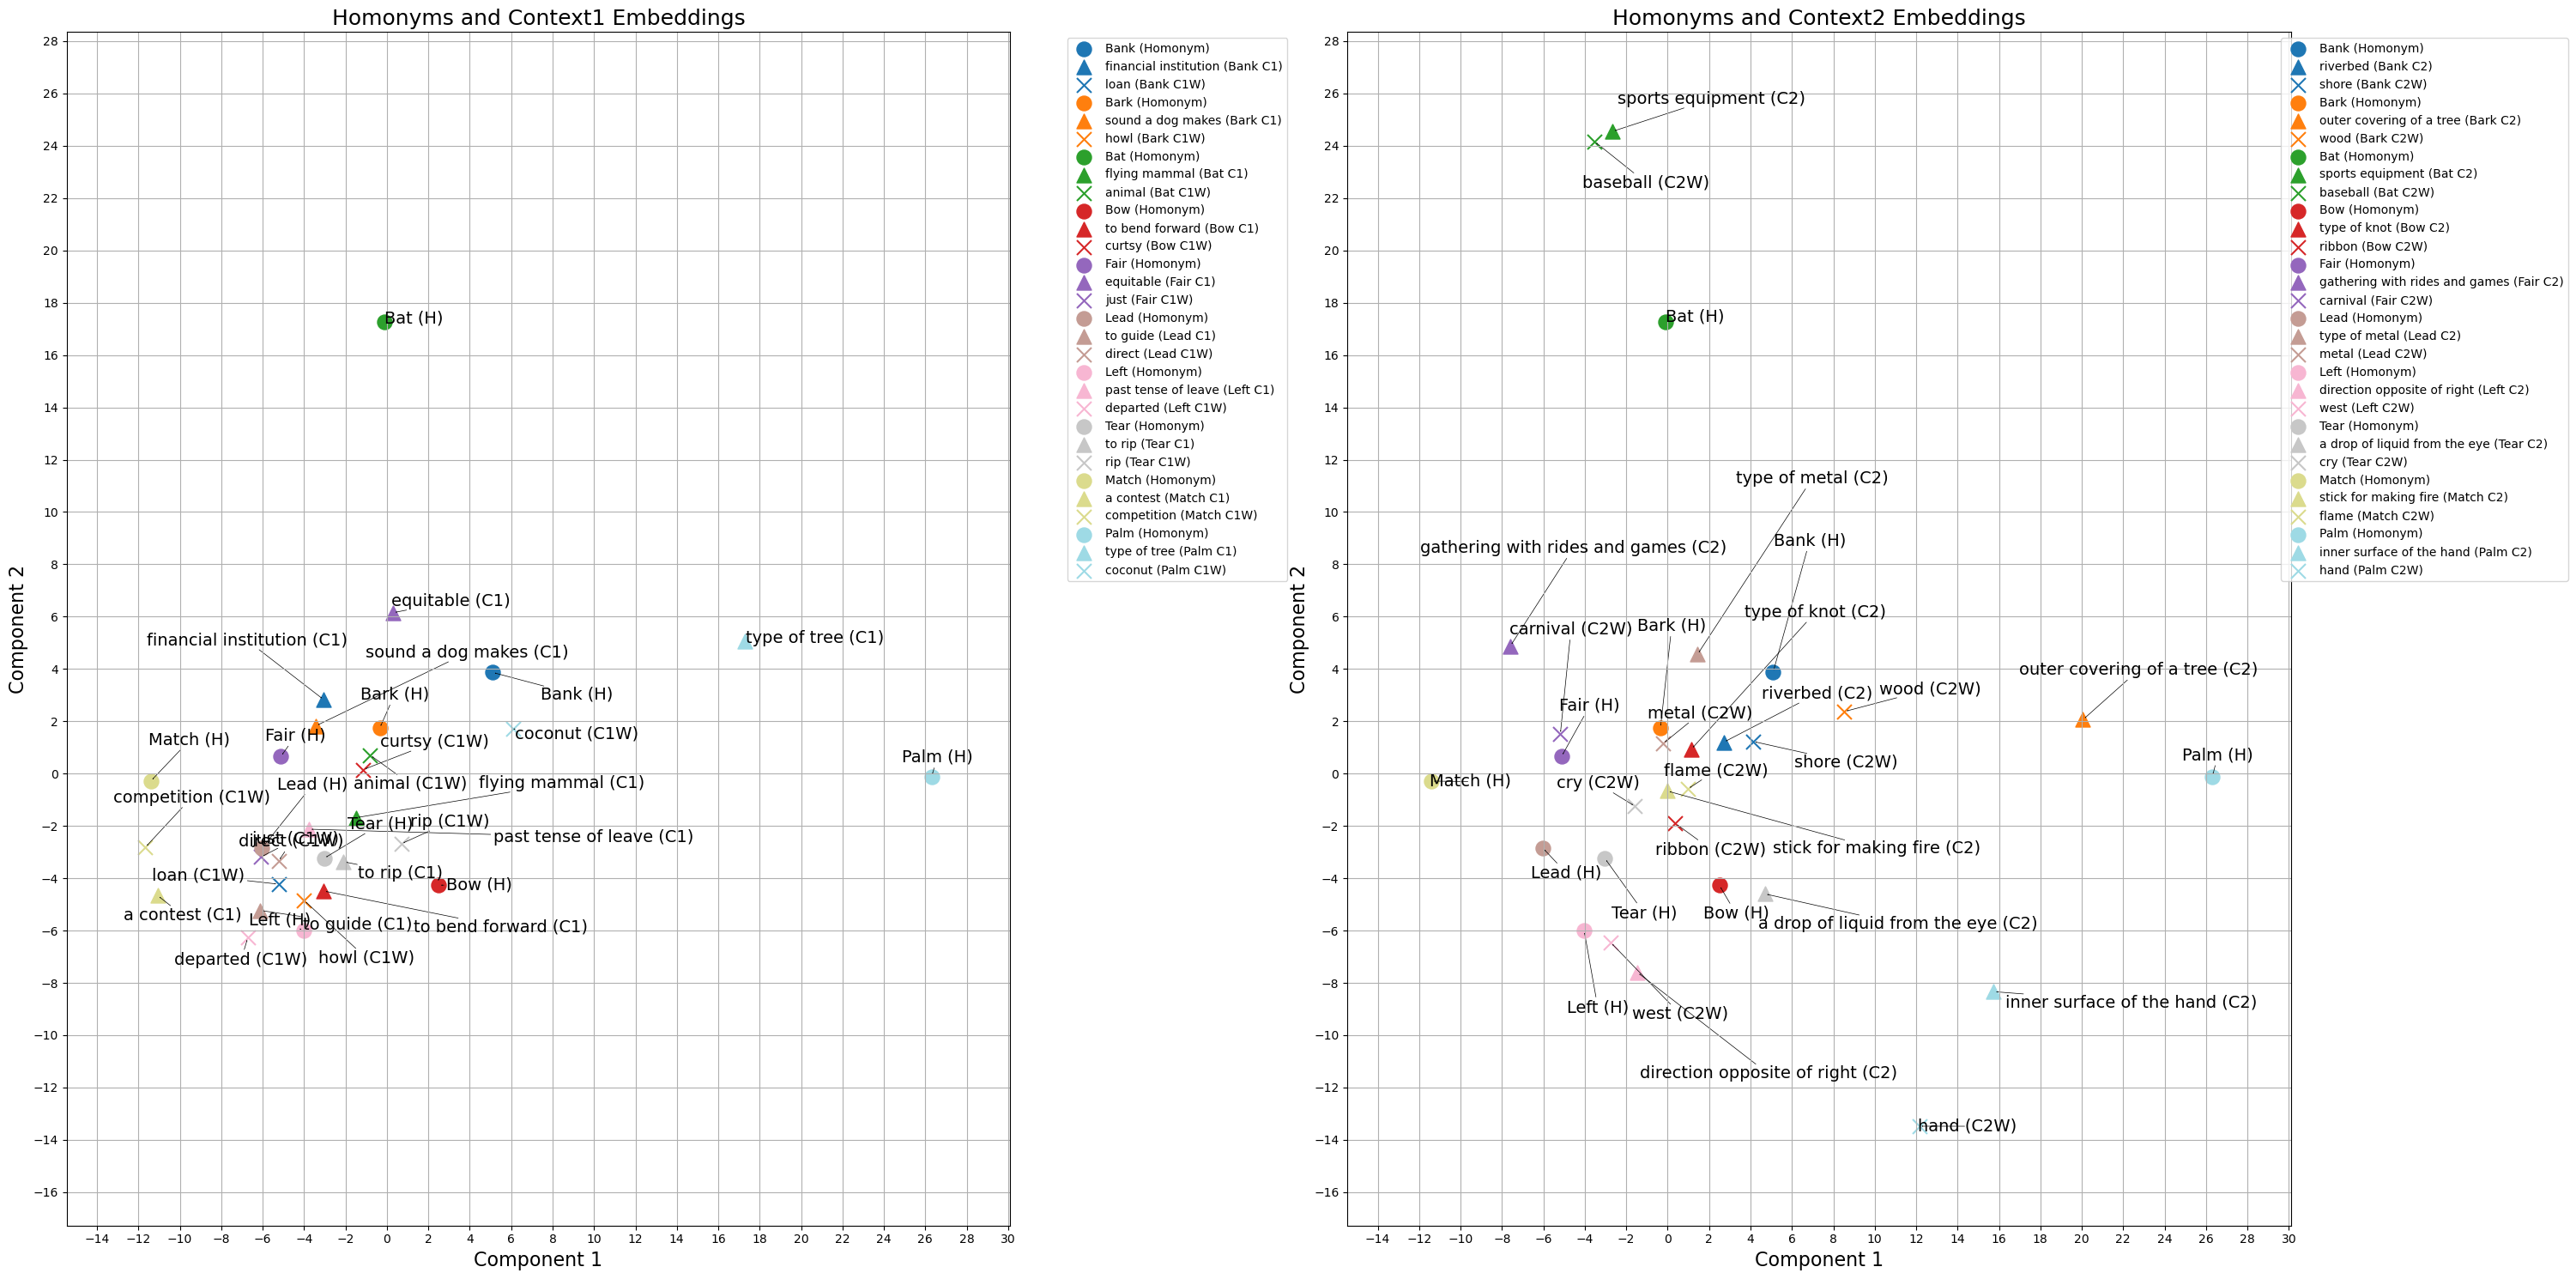

In [39]:
visualize_homonyms('english')

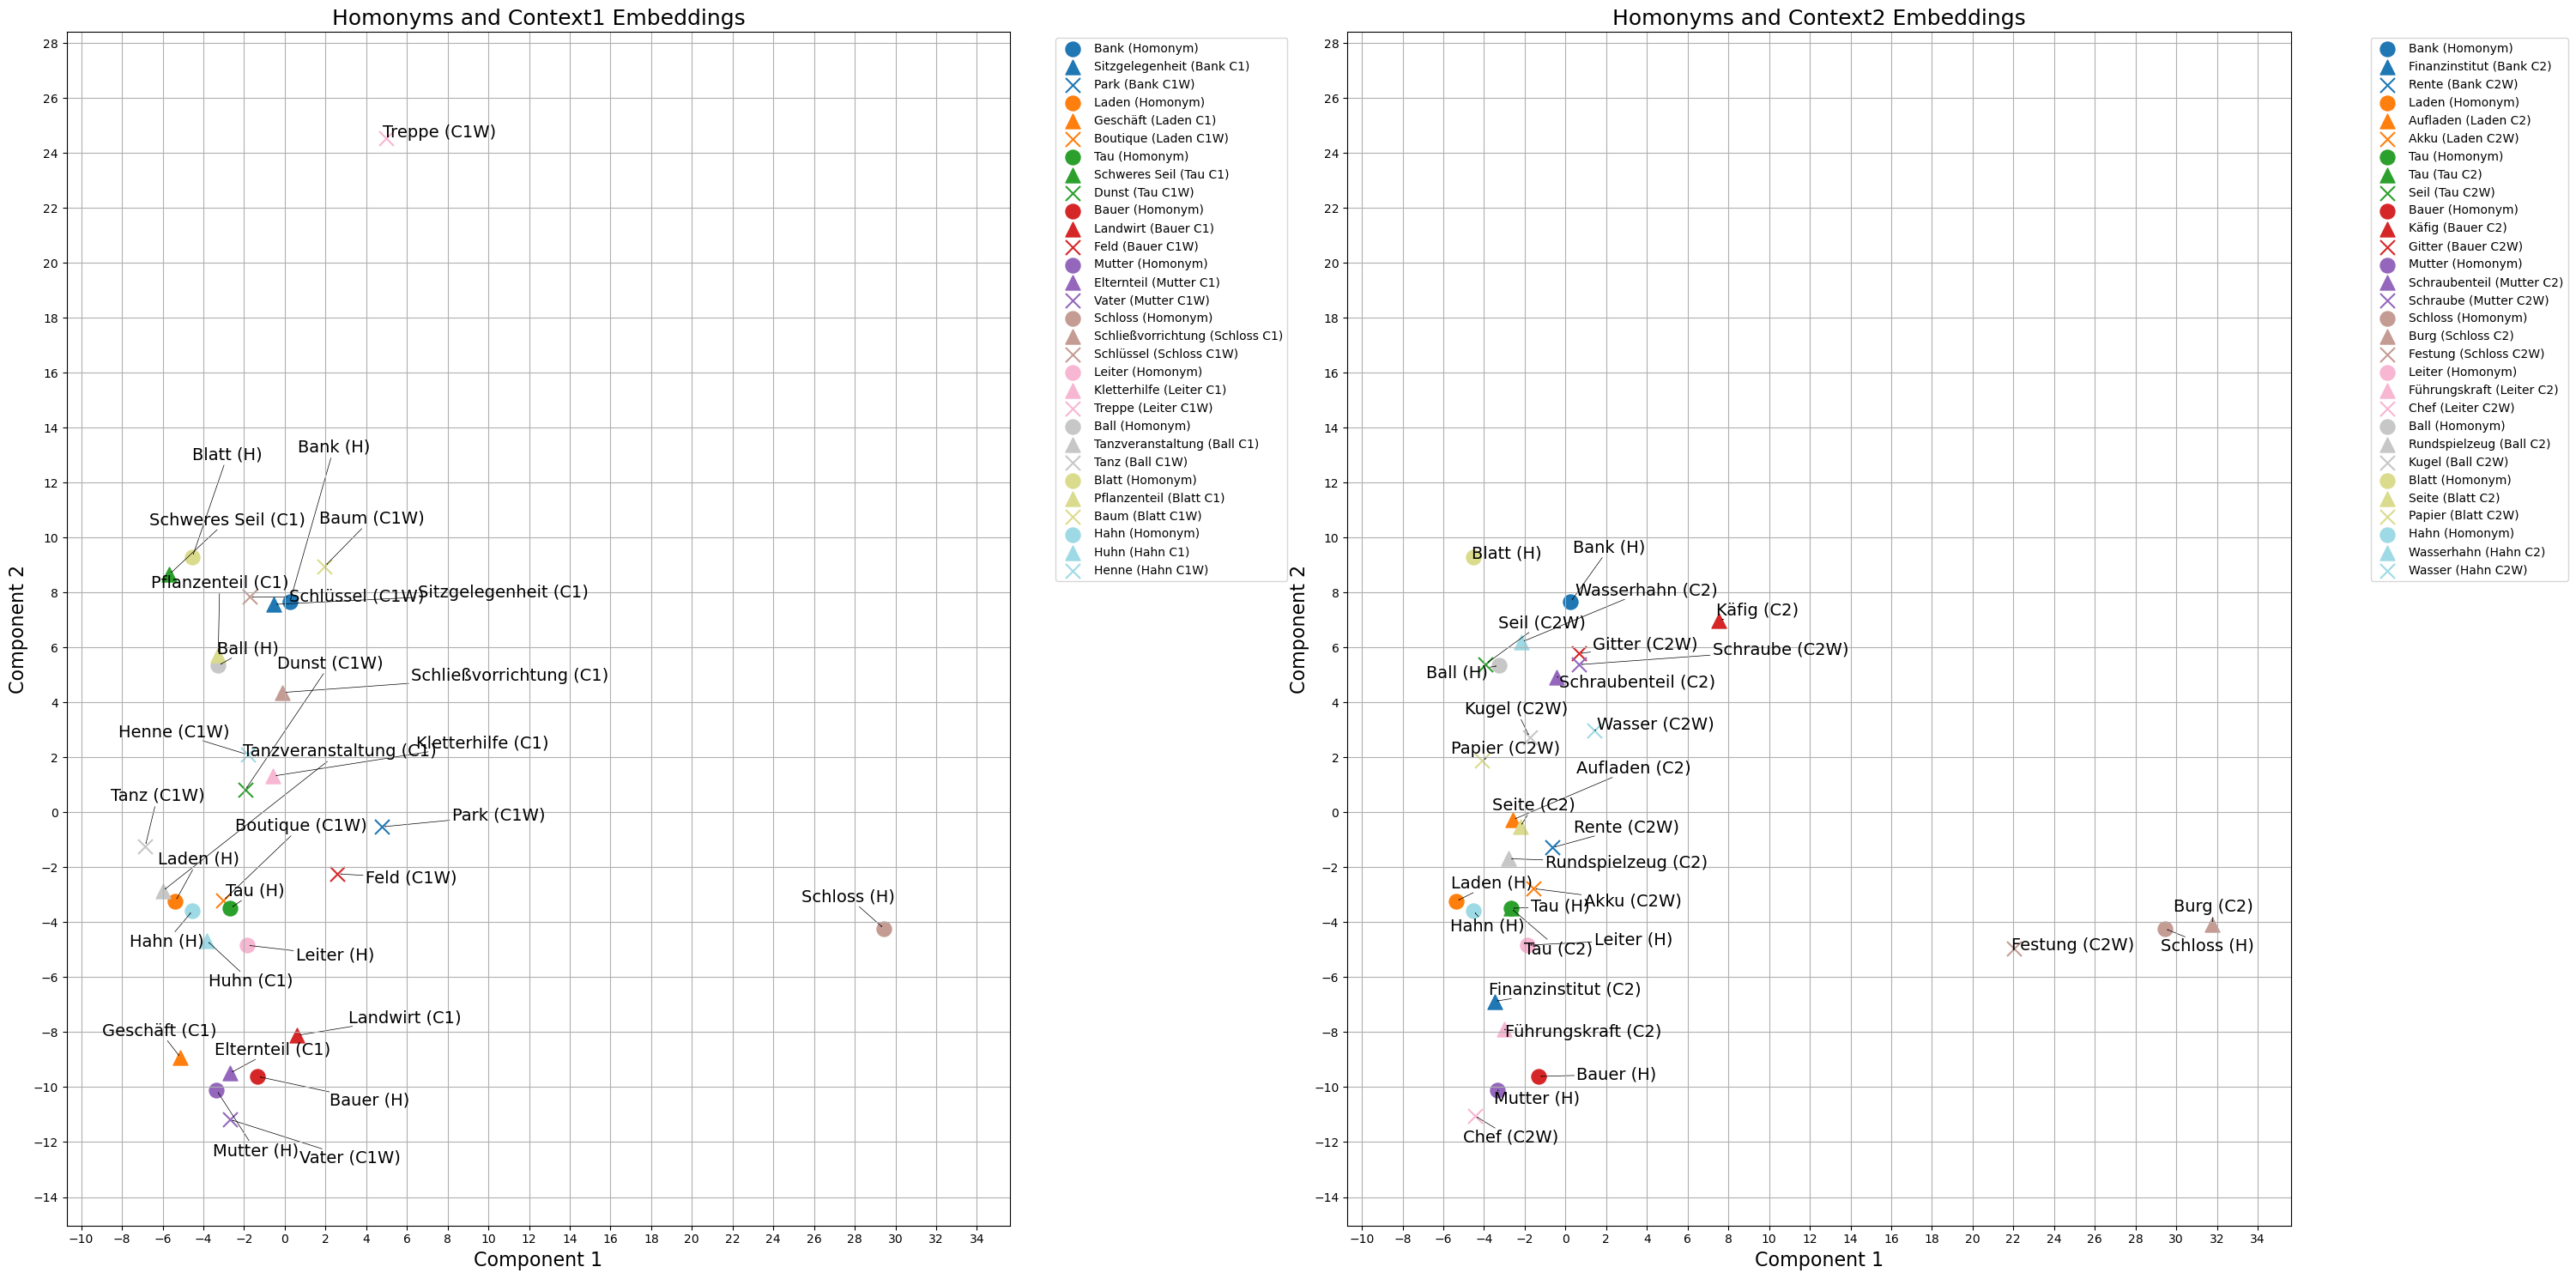

In [40]:
visualize_homonyms("german")

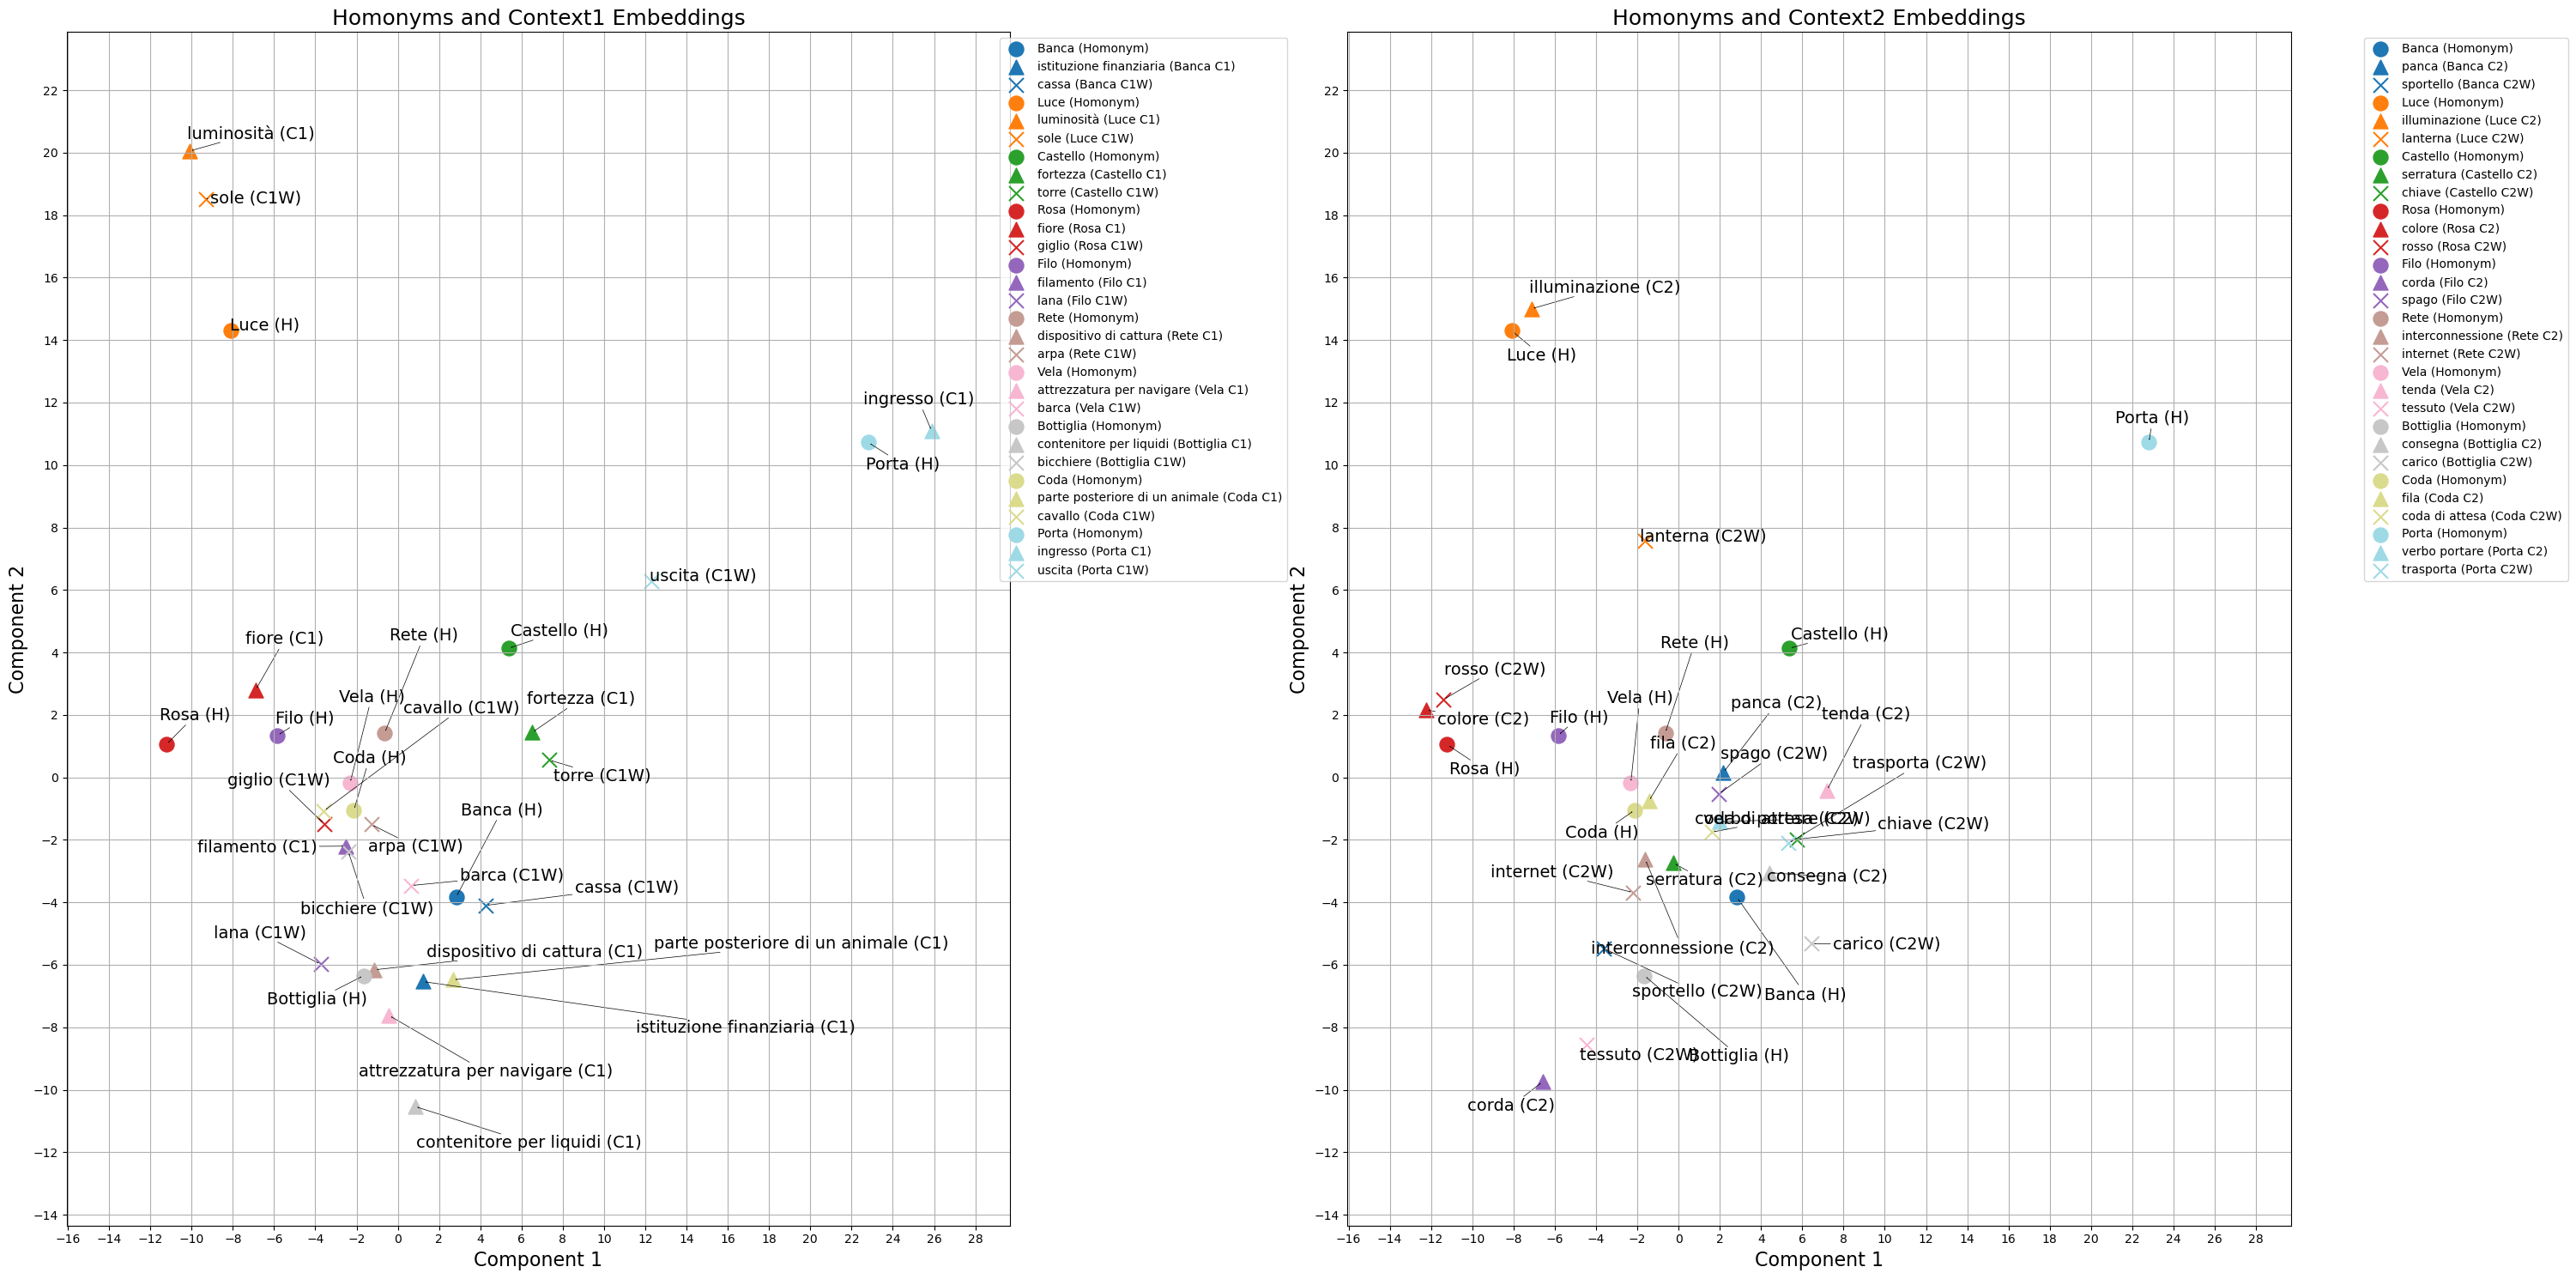

In [41]:
visualize_homonyms("italian")

### **Word Analogies Evaluation**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

  
def read_analogies(filepath):
    # Read analogies where the second word might have multiple possible answers
    df = pd.read_csv(filepath, header=None, names=["word_1", "word_2"], sep='\t')
    df = df.dropna()
    
    # Conver to excel format and rename the filepath to .xlsx
    df = df.reset_index(drop=True)
    
    # Save the dataframe as an excel file
    filepath = filepath.replace('.txt', '.xlsx')
    df.to_excel(filepath, index=False, header=False)
    return df

def get_embedding(word):
    # Replace this function with your actual embedding retrieval method
    return text_model([word]).cpu().detach().numpy().flatten()

def get_vocab_embeddings(vocab):
    embeddings = {}
    for word in vocab:
        embeddings[word] = get_embedding(word)
    return embeddings

def find_closest_word(analogy_vector, vocab_embeddings):
    max_similarity = -1
    closest_word = None
    for word, emb in vocab_embeddings.items():
        similarity = cosine_similarity([analogy_vector], [emb])[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            closest_word = word
    return closest_word, max_similarity

# For the analogies - a:b :: c:d
def evaluate_analogies(filepath, analogy_word_a, analogy_word_c):
    if filepath is None:
      raise ValueError("Please provide a filepath to the analogies file.")
    
    correct = 0
    total = 0
    
    analogies_df = read_analogies(filepath)
    
    # Define your vocabulary
    b_vocab = set(analogies_df['word_1'].str.split('/').sum())
    d_vocab = set(analogies_df['word_2'].str.split('/').sum())

    # Get embeddings for the entire vocabulary
    b_vocab_embeddings = get_vocab_embeddings(b_vocab)
    d_vocab_embeddings = get_vocab_embeddings(d_vocab)
    
    a_word_embds = get_embedding(analogy_word_a)
    c_word_embds = get_embedding(analogy_word_c)
    
    
    for i, row in analogies_df.iterrows():
        word_1, word_2 = row['word_1'], row['word_2']

        # Split word_2 if it has multiple correct answers
        possible_correct_words = word_2.split('/')
        
        try:
            b_word_embds = b_vocab_embeddings[word_1]
        except KeyError:
            print(f"Word '{word_1}' not in vocabulary. Skipping.")
            continue

        d_word_embds = b_word_embds - a_word_embds + c_word_embds

        predicted_word, similarity = find_closest_word(d_word_embds, d_vocab_embeddings)

        if predicted_word in possible_correct_words:
            correct += 1
        total += 1
        
        analogies_df.at[i, 'Predicted'] = predicted_word
        analogies_df.at[i, 'Similarity Score'] = similarity

    accuracy = correct / total if total > 0 else 0
    
    return analogies_df, accuracy, correct

In [35]:
import re

def evaluate_all_analogies(language):
  if language not in ['english', 'german', 'italian', 'russian']:
    raise ValueError("Language must be one of 'english', 'german', 'italian', 'russian'.")
  print(f'----- Evaluating {language.capitalize()} Analogies -----\n')
  
  dataset_path = './datasets/analogies'
  
  analogies_result = pd.DataFrame(columns=['Analogy', 'Accuracy', 'Correct'])
  i = 0
  for filename in os.listdir(f'{dataset_path}/{language}'):
    if filename.endswith('.txt'):
      regex = r'\[(.*?) - (.*?)\]'
      (word_a, word_c) = re.findall(regex, filename)[0]
      
      analogies_result.at[i, 'Analogy'] = f'{word_a} :: {word_c}'
      _, analogies_result.at[i, 'Accuracy'], analogies_result.at[i, 'Correct'] = evaluate_analogies(f'{dataset_path}/{language}/{filename}', word_a, word_c)
      i += 1
  
  return analogies_result, analogies_result['Accuracy'].mean()
  

In [38]:
result_english, mean_accuracy_english = evaluate_all_analogies('english')
print(f"Mean accuracy - English: {mean_accuracy_english:.3f}")
display(result_english)

----- Evaluating English Analogies -----

Mean accuracy - English: 0.218


,Analogy,Accuracy,Correct
0,country :: capital,0.0,0
1,country :: language,0.08,4
2,UK_city :: county,0.04,2
3,name :: nationality,0.04,2
4,name :: occupation,0.04,2
5,animal :: young,0.18,9
6,animal :: sound,0.02,1
7,animal :: shelter,0.12,6
8,things :: color,0.04,2
9,male :: female,0.24,12


In [24]:

result_german, mean_accuracy_german = evaluate_all_analogies('german')
print(f"Mean accuracy - German: {mean_accuracy_german:.3f}")
display(result_german)

----- Evaluating German Analogies -----

Mean accuracy - German: 0.190


,Analogy,Accuracy,Correct
0,things :: color,0.06,3
1,male :: female,0.32,16


In [25]:

result_italian, mean_accuracy_italian = evaluate_all_analogies('italian')
print(f"Mean accuracy - Italian: {mean_accuracy_italian:.3f}")
display(result_italian)

----- Evaluating Italian Analogies -----

Mean accuracy - Italian: 0.130


,Analogy,Accuracy,Correct
0,things :: color,0.06,3
1,male :: female,0.2,10


In [26]:

result_russian, mean_accuracy_russian = evaluate_all_analogies('russian')
print(f"Mean accuracy - Russian: {mean_accuracy_russian:.3f}")
display(result_russian)

----- Evaluating Russian Analogies -----

Mean accuracy - Russian: 0.150


,Analogy,Accuracy,Correct
0,things :: color,0.04,2
1,male :: female,0.26,13


### Evaluating lingual alignment ratio

In [27]:
import pandas as pd
import numpy as np

# If the ratio is greater than 1, it means that a is farther from b than b is from c. 
# If the ratio is less than 1, it means thata is closer to b than b is to c. 
# If the ratio is equal to 1, it means that the distances are equal.
def evaluate_alignment_ratio(source_analogies: pd.DataFrame, target_analogies: pd.DataFrame, source_language, target_language, source_context_word, target_context_word, column='word_1'):
    source_target_ratios = []
    target_source_ratios = []
    
    # Define your vocabulary
    source_vocab = source_analogies[column].str.split('/').sum()
    target_vocab = target_analogies[column].str.split('/').sum()

    # Get embeddings for the entire vocabulary
    source_embeddings = get_vocab_embeddings(source_vocab)
    target_embeddings = get_vocab_embeddings(target_vocab)
    
    source_context_embd = get_embedding(source_context_word)
    target_context_embd = get_embedding(target_context_word)
    
    d_source_target = np.linalg.norm(source_context_embd - target_context_embd)**2
    d_target_source = np.linalg.norm(target_context_embd - source_context_embd)**2
    
    for i, row in source_analogies.iterrows():
        source_word = row[column].split('/')[0]
        target_word = target_analogies.at[i, column].split('/')[0]
        
        source_instance_embd = source_embeddings[source_word]
        target_instance_embd = target_embeddings[target_word]

        source_target_ratio =  d_source_target / np.linalg.norm(source_context_embd - source_instance_embd)**2
        
        target_source_ratio = d_target_source / np.linalg.norm(target_context_embd - target_instance_embd)**2
        
        source_target_ratios.append(source_target_ratio)
        target_source_ratios.append(target_source_ratio)
    
    source_analogies['source_target_ratios'] = source_target_ratios
    target_analogies['target_source_ratios'] = target_source_ratios
        
    avg_source_target_ratio = np.mean(source_target_ratios)
    avg_target_source_ratio = np.mean(target_source_ratios)
    print(f"Average {source_language}-{target_language} ratio: {avg_source_target_ratio:.2f}")
    print(f"Average {target_language}-{source_language} ratio: {avg_target_source_ratio:.2f}")

    return source_analogies.merge(target_analogies, how="inner", left_index=True, right_index=True, suffixes=["_source", "_target"])



### 'Male' analogy context

In [28]:

# Read analogies for English and German
analogies_df_english = read_analogies('./datasets/analogies/english/E10 [male - female].txt')
analogies_df_german = read_analogies('./datasets/analogies/german/E10 [male - female].txt')
analogies_df_italian = read_analogies('./datasets/analogies/italian/E10 [male - female].txt')
analogies_df_russian = read_analogies('./datasets/analogies/russian/E10 [male - female].txt')

merged_ratio_eng_ger = evaluate_alignment_ratio(analogies_df_english, analogies_df_german, 'english', 'german', source_context_word='male', target_context_word='männlich')

merged_ratio_eng_ita = evaluate_alignment_ratio(analogies_df_english, analogies_df_italian, 'english', 'italian', source_context_word='male', target_context_word='maschio')

merged_ratio_eng_rus = evaluate_alignment_ratio(analogies_df_english, analogies_df_russian, 'english', 'russian', source_context_word='male', target_context_word='мужской')

Average english-german ratio: 0.74
Average german-english ratio: 0.96
Average english-italian ratio: 1.15
Average italian-english ratio: 1.10
Average english-russian ratio: 1.15
Average russian-english ratio: 1.51


### 'Female' analogy context

In [29]:
merged_ratio_eng_ger = evaluate_alignment_ratio(analogies_df_english, analogies_df_german, 'english', 'german', source_context_word='female', target_context_word='weiblich', column='word_2')

merged_ratio_eng_ita = evaluate_alignment_ratio(analogies_df_english, analogies_df_italian, 'english', 'italian', source_context_word='female', target_context_word='femmina', column='word_2')

merged_ratio_eng_rus = evaluate_alignment_ratio(analogies_df_english, analogies_df_russian, 'english', 'russian', source_context_word='female', target_context_word='женский', column='word_2')

Average english-german ratio: 0.10
Average german-english ratio: 0.11
Average english-italian ratio: 0.13
Average italian-english ratio: 0.12
Average english-russian ratio: 0.13
Average russian-english ratio: 0.13


### 'Things' analogy context

In [30]:
# Read analogies for English and German
analogies_df_english = read_analogies('./datasets/analogies/english/E09 [things - color].txt')
analogies_df_german = read_analogies('./datasets/analogies/german/E09 [things - color].txt')
analogies_df_italian = read_analogies('./datasets/analogies/italian/E09 [things - color].txt')
analogies_df_russian = read_analogies('./datasets/analogies/russian/E09 [things - color].txt')

merged_ratio_eng_ger = evaluate_alignment_ratio(analogies_df_english, analogies_df_german, 'english', 'german', source_context_word='things', target_context_word='dinge')

merged_ratio_eng_ita = evaluate_alignment_ratio(analogies_df_english, analogies_df_italian, 'english', 'italian', source_context_word='things', target_context_word='cose')

merged_ratio_eng_rus = evaluate_alignment_ratio(analogies_df_english, analogies_df_russian, 'english', 'russian', source_context_word='things', target_context_word='вещи')

Average english-german ratio: 0.32
Average german-english ratio: 0.56
Average english-italian ratio: 0.04
Average italian-english ratio: 0.04
Average english-russian ratio: 0.04
Average russian-english ratio: 0.03


### 'Colors' analogy context

In [31]:
# Read analogies for English and German
analogies_df_english = read_analogies('./datasets/analogies/english/E09 [things - color].txt')
analogies_df_german = read_analogies('./datasets/analogies/german/E09 [things - color].txt')
analogies_df_italian = read_analogies('./datasets/analogies/italian/E09 [things - color].txt')
analogies_df_russian = read_analogies('./datasets/analogies/russian/E09 [things - color].txt')

merged_ratio_eng_ger = evaluate_alignment_ratio(analogies_df_english, analogies_df_german, 'english', 'german', source_context_word='colors', target_context_word='Farben', column='word_2')

merged_ratio_eng_ita = evaluate_alignment_ratio(analogies_df_english, analogies_df_italian, 'english', 'italian', source_context_word='colors', target_context_word='colori', column='word_2')

merged_ratio_eng_rus = evaluate_alignment_ratio(analogies_df_english, analogies_df_russian, 'english', 'russian', source_context_word='colors', target_context_word='цвета', column='word_2')

Average english-german ratio: 0.01
Average german-english ratio: 0.01
Average english-italian ratio: 0.04
Average italian-english ratio: 0.04
Average english-russian ratio: 0.02
Average russian-english ratio: 0.02


___